Pré-processamento e reconhecimento das etiquetas
===
---

### Objetivos
1. Reconhecimento da etiqueta
2. Leitura do código de barra
3. Reconhecimento dos caracteres da TAG

# Pré-processamento

Importando as bibliotecas

In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

cv2.__version__

'4.8.0'

Carregando todas as imagem da pasta:

In [3]:
dir_path = '/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos'

files = os.listdir(dir_path)
images_list = []

for file in files:
    img_path = os.path.join(dir_path, file)
    print(img_path)
    source = cv2.imread(img_path)
    images_list.append(source)

/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos/IMG_20230707_172939.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos/IMG_20230707_173217.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos/IMG_20230707_172655.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos/IMG_20230707_182238.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos/IMG_20230707_182432.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos/IMG_20230707_181950.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos/IMG_20230707_172624.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos/IMG_20230707_181942.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos/IMG_20230707_182001.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos/IMG_20230707_182251.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos/IMG_20230707_182003.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos/IMG_20230707_182016.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos/IMG_20230707_172558.jpg
/home/nodyer/Área de Trabalho/TG Nodye

Selecionando a imagem e redefinindo o seu tamanho:

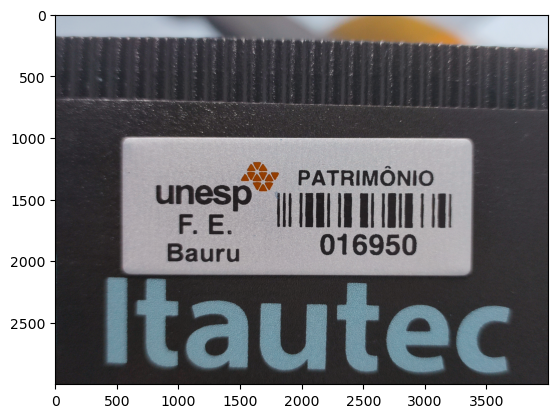

In [383]:
# Carrega a imagem
scr = images_list[10]

# Define a porcentagem de redimensionamento
percent = 10

# Calcula as novas dimensões da imagem
width = int(scr.shape[1] * percent / 100)
height = int(scr.shape[0] * percent / 100)

# Redimensiona a imagem
#scr = cv2.resize(scr, (width, height), interpolation = cv2.INTER_AREA)

#Exibe a imagem
plt.imshow(scr)
plt.show()

In [381]:
scr = cv2.rotate(scr, cv2.ROTATE_90_CLOCKWISE)

Alterando para grayscale:

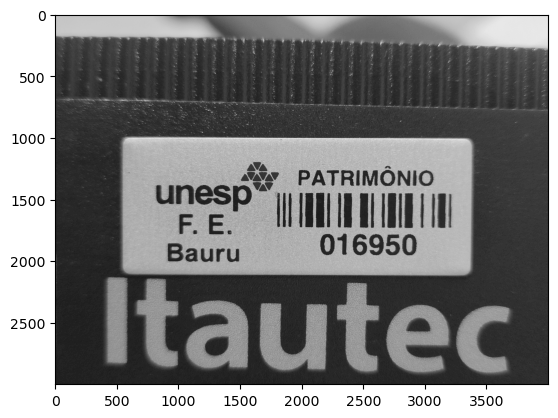

In [384]:
gray = cv2.cvtColor(scr, cv2.COLOR_BGR2GRAY)

#Exibe a imagem
plt.imshow(gray, 'gray')
plt.show()

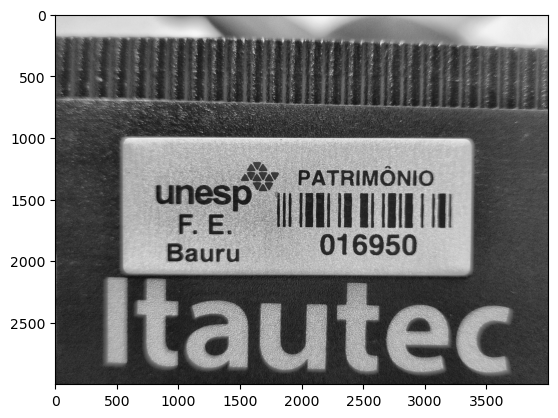

In [385]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl = clahe.apply(gray)
plt.imshow(cl, 'gray')
plt.show()

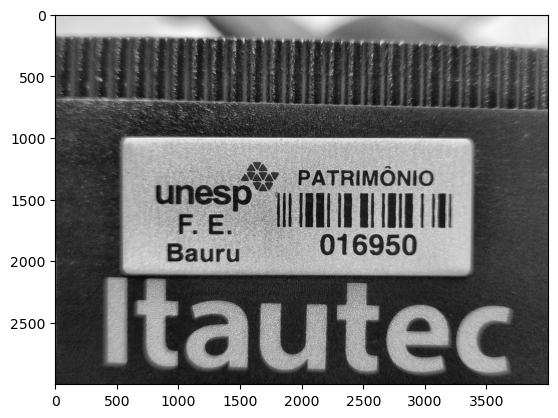

In [386]:
median = cv2.medianBlur(cl,5)
plt.imshow(median, 'gray')
plt.show()

Aplicando Gaussian blur:

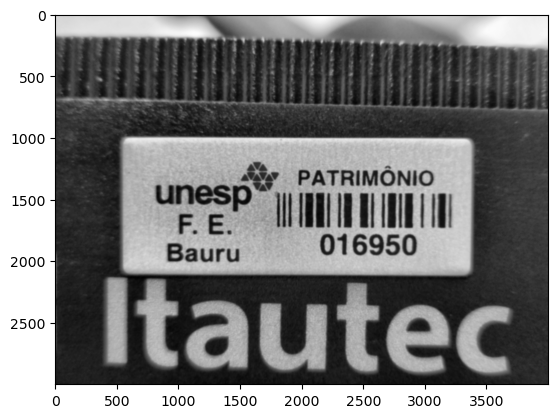

In [387]:
blur = cv2.GaussianBlur(cl, (31,31), 0)
plt.imshow(blur, 'gray')
plt.show()

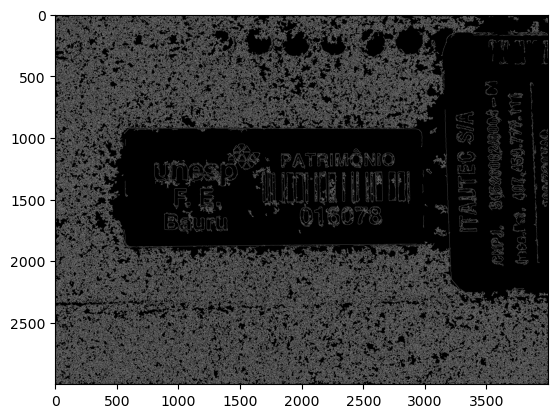

In [345]:
edges = cv2.Canny(median, 30, 200) 
plt.imshow(edges, 'gray')
plt.show()

Aplicando Threshold:

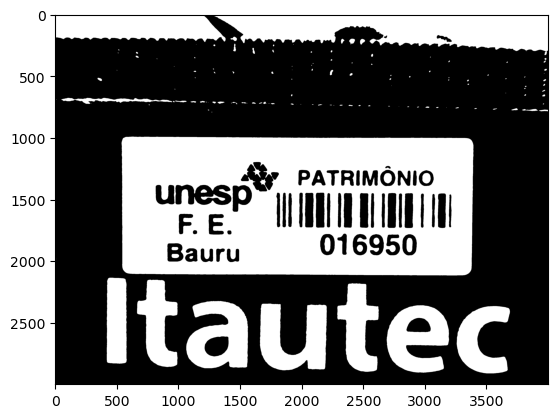

In [388]:
_, thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#Exibe a imagem
plt.imshow(thresh, 'gray')
plt.show()

# Reconhecimento da etiqueta

A estratégia partirá da detecção de contorno e retangulos na imagem.

Contornos encontrados:  201


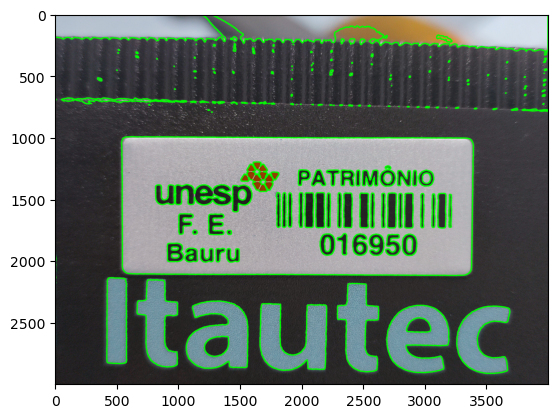

In [389]:
img_copy = np.copy(scr)
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

print("Contornos encontrados: ", len(contours))

# Visualizando os contornos
cv2.drawContours(img_copy, contours, -1, (0, 255, 0), 10)

plt.imshow(img_copy)
plt.show()

Como essa estratégia pode encontrar inúmeros retangulos no imagem que não são de nosso interesse, será tomado a razão da altura e largura da etiqueta como referência para a condição de qual retangulo queremos encontrar.

In [390]:
razao_TAG = 4.6/1.8
print("Razão: ", razao_TAG)

Razão:  2.5555555555555554


Área:  3214730
Razão:  2.535523978685613
Conta1:  2.3
Conta2:  2.811111111111111
Área:  906759
Razão:  8.177177177177176
Placas detectadas:  1


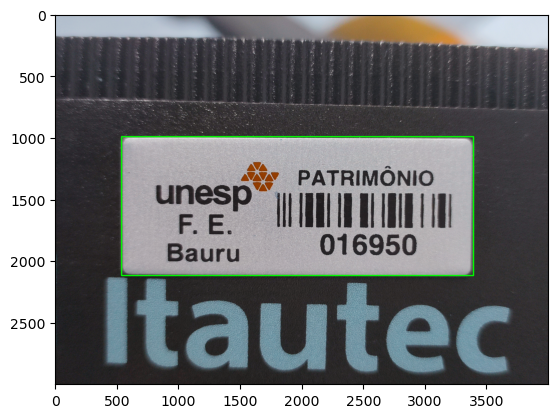

In [391]:
roi_list = []
img_copy2 = np.copy(scr)
for c in contours:
    # Perímetro
    epsilon = cv2.arcLength(c, True)

    if epsilon > 6000:
        # Aproximando o perímetro
        approx = cv2.approxPolyDP(c, 0.03 * epsilon, True)
        #print(approx)

        x,y,w,h = cv2.boundingRect(c)
        #cv2.rectangle(img_copy2,(x,y),(x+w,y+h),(0,255,0), 2)

        area = int(w) * int(h)
        print('Área: ', area)

        if area > 19000:
            razao_cont = w/h
            print('Razão: ', razao_cont)

            if razao_cont >= (razao_TAG - 0.1*razao_TAG) and razao_cont <= (razao_TAG + 0.1*razao_TAG):
                print('Conta1: ', razao_TAG - 0.1*razao_TAG)
                print('Conta2: ', razao_TAG + 0.1*razao_TAG)
                cv2.rectangle(img_copy2,(x,y),(x+w,y+h),(0,255,0),10)
                roi_list.append(c)

print('Placas detectadas: ', len(roi_list))

plt.imshow(img_copy2)
plt.show()

Por fim, será feito o recorte da imagem isolando a etiqueta no fundo, ou seja, uma região de interesse (ROI).

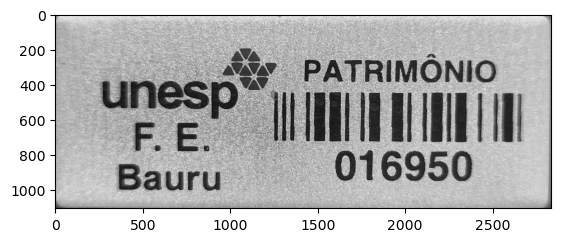

In [392]:
roi_cut_list = []

for item in roi_list:
    x,y,w,h = cv2.boundingRect(item)
    cut = cl[y+10:y+h-10,x+10:x+w-10]
    roi_cut_list.append(cut)

    #print(len(roi_list))
    #print(len(roi_cut_list))
    plt.subplot(1, len(roi_list), len(roi_cut_list))
    plt.imshow(cut, 'gray')

plt.show()

In [393]:
from pyzbar.pyzbar import decode

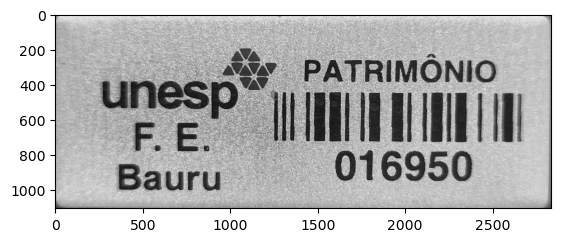

In [394]:
plt.imshow(cut, 'gray')
plt.show()

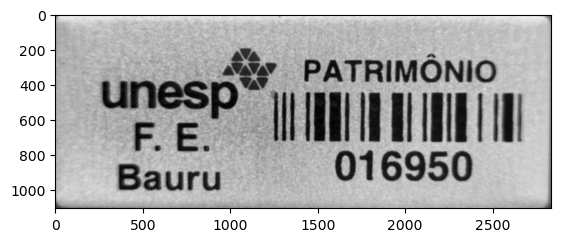

In [395]:
roi = cv2.GaussianBlur(cut, (21,21), 0)
plt.imshow(roi, 'gray')
plt.show()

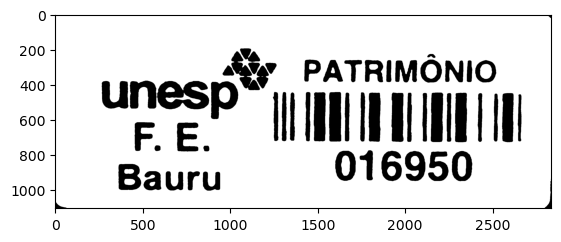

In [396]:
_, roi = cv2.threshold(roi,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
_, roi2 = cv2.threshold(roi,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.imshow(roi, 'gray')
plt.show()

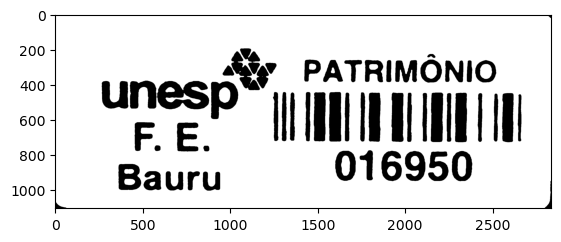

In [397]:
roi = cv2.medianBlur(roi,5,30)
plt.imshow(roi, 'gray')
plt.show()

In [398]:
for code in decode(roi):
    print(code.type)
    print(code.data.decode('utf-8'))

I25
016950


1246 458 1420 262


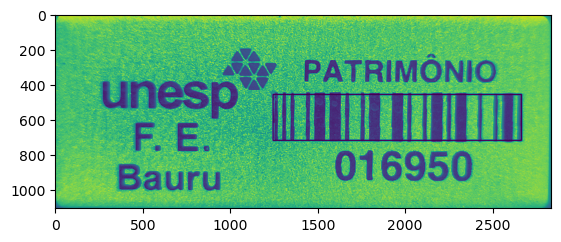

In [399]:
barcodes = decode(roi)
x, y, w, h = barcodes[0].rect
print(x,y,w,h)

draw_bar = np.copy(cut)
cv2.rectangle(draw_bar,(x,y),(x+w,y+h),(0,255,0), 7)

plt.imshow(draw_bar)
plt.show()

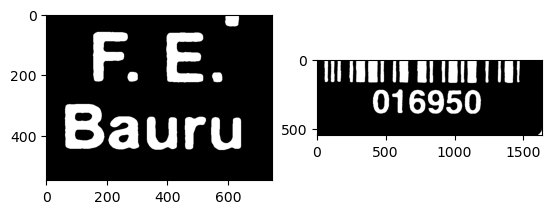

In [400]:
unidade = roi2[y+100:,300:x-200]
barra = roi2[y+100:,x-50:]

plt.subplot(1,2,1)
plt.imshow(unidade,'gray')
plt.subplot(1,2,2)
plt.imshow(barra, 'gray')
plt.show()

Caracteres detectados:  FE
Bauru

Números detectados:  016950



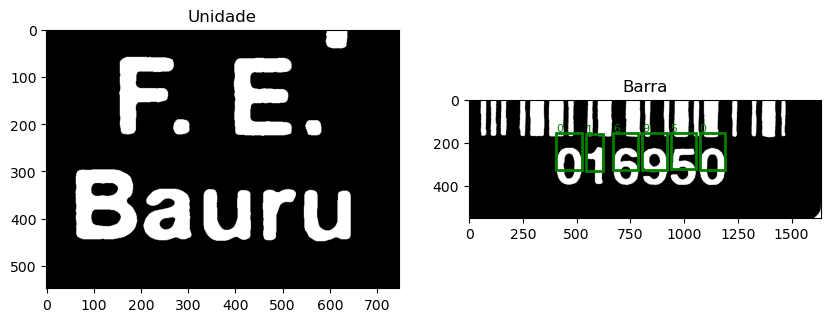

In [401]:
import pytesseract
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

config_char = r'-c tessedit_char_whitelist=AaBbCcDdEeFfGgHhIiJjKkLlMmNnOoPpQqRrSsTtUuVvWwXxYyZz --psm 6 --oem 1'
config_num = r'-c tessedit_char_whitelist=0123456789 --psm 6 --oem 1'

# Obtém os resultados do OCR
chars = pytesseract.image_to_string(unidade, lang='por', config=config_char)
numbers = pytesseract.image_to_string(barra, lang='eng', config=config_num)

print('Caracteres detectados: ', chars)
print('Números detectados: ', numbers)

# Função para desenhar caixas nas letras detectadas
def desenhar_caixas(ax, imagem, texto):
    caixas = pytesseract.image_to_boxes(imagem, config=config_num)
    for caixa in caixas.splitlines():
        caixa = caixa.split()
        x, y, w, h = int(caixa[1]), int(caixa[2]), int(caixa[3]), int(caixa[4])
        retangulo = Rectangle((x, y), w - x, h - y, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(retangulo)
        ax.text(x, y - 10, caixa[0], color='g', fontsize=8)

# Cria uma figura com subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Desenha caixas nas letras detectadas nas imagens
desenhar_caixas(axs[0], unidade, chars)
axs[0].imshow(cv2.cvtColor(unidade, cv2.COLOR_BGR2RGB))
axs[0].set_title('Unidade')

desenhar_caixas(axs[1], barra, numbers)
axs[1].imshow(cv2.cvtColor(barra, cv2.COLOR_BGR2RGB))
axs[1].set_title('Barra')

# Exibe a figura
plt.show()
